In [1]:
# Libraries

import sys
import math
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
from datetime import datetime, timedelta
import folium
import webbrowser
import win32com.client as win32

In [2]:
# Inital information

# url without under offer properties
url_wo_uo = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-1?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
# url including under offer properties
url_inc_uo = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-1?filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
html = requests.get(url_inc_uo)
soup = bs(html.text, 'html.parser')

body = soup.find('body')
header = body.find('div', class_ = 'results-header mt-5')
property_count = int(header.find('div', class_ = 'results-message').contents[0].strip())
pages_needed = math.ceil(property_count / 24)
# extra pages only include featured properties - so doesn't go past max. page index.

print(f"There are {property_count} properties on the website currently.\nSo {pages_needed} pages are needed.")

There are 89 properties on the website currently.
So 4 pages are needed.


In [4]:
# Function for getting links

def get_links(soup):
    links = []

    i = 1
    max_iterations = 30
    while len(links) < 24 and i <= max_iterations:
        elements = soup.select(f"body > div.container.mt-3 > div.results.row > div:nth-child({i}) > div.card.h-100.card--results > a")
        # Featured properties still appear elsewhere - so aren't needed. It also causes a break when an empty page is reached.
        # Under offer properties also appear elsewhere or the element path is the same idk.
        # if not elements:
        #     elements = soup.select(f"body > div.container.mt-3 > div.results.row > div:nth-child({i}) > div.card.h-100.card--under-offer > a")

        if not elements:
            i += 1
            continue

        for element in elements:
            href = element['href']
            link = 'https://propertylink.estatesgazette.com'+ href
            links.append(link)
        i += 1

    return links


all_links = get_links(soup)


In [5]:
# Looping through pages

base_url = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-{}?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
# url without under offer properties
url_wo_uo = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-{}?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
# url including under offer properties
url_inc_uo = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-{}?filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'

all_links = []  # Store all links from all pages

for page_num in range(1, pages_needed+1):  
    url = url_inc_uo.format(page_num)
    html = requests.get(url)
    soup = bs(html.text, 'html.parser')
    
    page_links = get_links(soup)
    all_links.extend(page_links)  # Add the links from this page to the all_links list

    print(f"Page {page_num} has {len(page_links)} links.")

property_links = list(set(all_links)) # removing duplicates
print(f"Total links collected: {len(property_links)}")


Page 1 has 24 links.
Page 2 has 24 links.
Page 3 has 24 links.
Page 4 has 17 links.
Total links collected: 89


In [6]:
# Single property test

single_link = property_links[4]
single_link = 'https://propertylink.estatesgazette.com/property-details/6987959-suite-5-western-house-2-rush-hill-bath-somerset-ba2-2qh'
print(single_link)

html = requests.get(single_link)
soup = bs(html.text, 'html.parser')

# soup.select('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-name')
agent_name = soup.find('div', class_='agent-name').find_all_next(string=True)[1].strip()


agency_name = soup.select_one('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-logo > img')
if agency_name == None:
    agency_name = soup.select_one('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-logo > a > img')
agency_name = agency_name['alt']

agency_name = soup.find("meta", {"name": "gwa_advertiserName"})
agency_name = agency_name.get("content")



id_tag = soup.find("meta", {"name": "gwa_contentID"})
id_tag = id_tag.get("content")

# address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(3)') # Full div
# address = address[0].get_text(strip=True) # gives address with below stuck to the front
# address = address.replace("ADDRESS", "").strip() #tidy

address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > h1')
address = address[0].get_text(strip=True)
address = address.replace("sharebookmark", "").strip() #tidy

size = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(2)')
size = size[0].get_text(strip=True) # gives size with below stuck to the front
size = size.replace("SIZE", "").strip() #tidy

type = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(4)')
type = type[0].get_text(strip=True)
type = type.replace("TYPE", "").strip()

price = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(1)')
price = price[0].get_text(strip=True)
price = price.replace("TO RENT", "").strip()

date_posted = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(6)')
date_posted = date_posted[0].get_text(strip=True)
date_posted = date_posted.replace("POSTED ON", "").strip()

desc = soup.select_one('body > div:nth-of-type(4) > div:nth-of-type(2) > div > div:nth-of-type(5) > div > div:nth-of-type(1)')
desc = desc.get_text(strip=True)

latitude = soup.find('meta', itemprop='latitude')['content']
longitude = soup.find('meta', itemprop='longitude')['content']


try:
    under_offer = soup.select_one('#tab-details > div.results__single-badge.badges.badges--under-offer')
    under_offer = under_offer.get_text(strip=True)
except:
    under_offer = ''

print(f'Agent Name: {agent_name}')
print(f'Agency Name: {agency_name}')
print(f'ID: {id_tag}')
print(f'Address: {address}')
print(f'Size: {size}')
print(f'Type: {type}')
print(f'Price: {price}')
print(f'Date Posted: {date_posted}')
print(f'Description: {desc}\n')
print('Coords: ',latitude, ',', longitude)
print(f'Offer Status: {under_offer}')




https://propertylink.estatesgazette.com/property-details/6987959-suite-5-western-house-2-rush-hill-bath-somerset-ba2-2qh
Agent Name: Maddie Pyles
Agency Name: CSquared (Previously Colston & Colston Chartered Surveyors)
ID: 6987959
Address: Suite 5 Western House, 2 Rush Hill, Bath, Somerset, BA2 2QH
Size: 219 Sq Ft
Type: Office, Offices
Price: £10,200.00  Per  Annum
Date Posted: 1st November 2024
Description: The property comprises well-lit, open plan office space with own kitchen and WC facilities. This office suite is at first floor level and has a private double glazed access via a set of external stairs. The entrance is located to the rear of the main building, via a path to the right-hand side. The unit also benefits from one designated on-site car parking space, and on-street parking available nearby( Agency Pilot Software ref: 907 )

Coords:  51.365498 , -2.394481
Offer Status: 


In [7]:
# Collecting all property information

def assign_value(elements, keyword):
    for element in elements:
        text = element.get_text(strip=True)
        if keyword in text:
            return text.replace(keyword, "").strip()
    return None

property_data = []

for property in property_links:
    # print(property)
    html = requests.get(property)
    soup = bs(html.text, 'html.parser')

    agent_name = soup.find('div', class_='agent-name').find_all_next(string=True)[1].strip()
    
    agency_name = soup.find("meta", {"name": "gwa_advertiserName"})
    agency_name = agency_name.get("content")

    id_tag = soup.find("meta", {"name": "gwa_contentID"})
    id_tag = id_tag.get("content")

    desc = soup.select_one('body > div:nth-of-type(4) > div:nth-of-type(2) > div > div:nth-of-type(5) > div > div:nth-of-type(1)')
    desc = desc.get_text(strip=True)

    # address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > h1')
    # address = address[0].get_text(strip=True)
    # address = address.replace("sharebookmark", "").strip() #tidy

    elements = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div')

    # Assign values based on keywords - thank you ChatGPT for this one...
    price = assign_value(elements, "TO RENT")
    size = assign_value(elements, "SIZE")
    address = assign_value(elements, "ADDRESS")
    type = assign_value(elements, "TYPE")
    # tenure = assign_value(elements, "TENURE")
    date_posted = assign_value(elements, "POSTED ON")

    latitude = soup.find('meta', itemprop='latitude')['content']
    longitude = soup.find('meta', itemprop='longitude')['content']

    try:
        under_offer = soup.select_one('#tab-details > div.results__single-badge.badges.badges--under-offer')
        under_offer = under_offer.get_text(strip=True)
    except:
        under_offer = ''
    

    property_data.append({
        'Id': id_tag,
        'Offer Status': under_offer,
        'Address': address,
        'Price': price,
        'Size': size,
        'Property Type': type,
        'Agency Name': agency_name,
        'Agent Name': agent_name,
        'Description': desc,
        'Property Link': property,
        'Date Posted': date_posted,
        'Latitude': latitude,
        'Longitude': longitude
    })

    

df = pd.DataFrame(property_data)



df.head(2)

,Id,Offer Status,Address,Price,Size,Property Type,Agency Name,Agent Name,Description,Property Link,Date Posted,Latitude,Longitude
0,6984798,,"First Floor, 27A Westgate Street, Bath, BA1 1EP","£8,000.00 Per Annum",529 Sq Ft,"Office, Offices, Land, Commercial Land",James Armitage,James Armitage,Grade II Listed Georgian buildingCity centre l...,https://propertylink.estatesgazette.com/proper...,15th October 2024,51.3814822,-2.3617323
1,6976873,,"Second Floor, 25 Windsor Castle, Upper Bristol...","£17,500.00 Per Annum","1,032 Sq Ft","Office, Offices",CSquared (Previously Colston & Colston Charter...,Maddie Pyles,SECOND FLOOR OPEN PLAN OFFICE WITH PARKING TO ...,https://propertylink.estatesgazette.com/proper...,28th October 2024,51.3842868,-2.381915


In [8]:
# Writing to csv (NEED TO SWAP BETWEEN UNDER OFFER AND NORMAL!!!)

today = datetime.now()
last_week = today - timedelta(weeks=1)
today = today.strftime("%d.%m.%y")
last_week = last_week.strftime("%d.%m.%y")
df.to_csv(f'EG_scraped_{today}.csv', index=False, sep=',', encoding='utf-8-sig', header=True, quotechar='"')
# df.to_csv(f'EG_underoffers_{today}.csv', index=False, sep=',', encoding='utf-8-sig', header=True, quotechar='"')

In [19]:
# Comparison w/ last week & writing changes to xlsx


today = datetime.now()
last_week = today - timedelta(weeks=1)
today = today.strftime("%d.%m.%y")
last_week = last_week.strftime("%d.%m.%y")
print(today)
df_old = pd.read_csv(f'EG_scraped_{last_week}.csv')
# df_old = pd.read_csv(f'EG_scraped_03.12.24.csv')
df_new = pd.read_csv(f'EG_scraped_{today}.csv')
# df_new = pd.read_csv(f'EG_scraped_02.12.24.csv')

df_old.head()

key = 'Id'
df_dropped = df_old[~df_old[key].isin(df_new[key])]
# df_dropped.head()
# df_dropped.to_csv('dropped_5.11.24.csv', index=False)

df_posted = df_new[~df_new[key].isin(df_old[key])]
# df_posted.info()
# df_posted.head()
# df_posted.to_csv('posted_5.11.24.csv', index=False)



df_posted['Website Status'] = 'Added'
df_dropped['Website Status'] = 'Dropped'

df_posted['Offer Status'] = ''
df_dropped['Offer Status'] = ''

df_common = pd.merge(df_old[['Id','Offer Status']], df_new, on=key, suffixes=('_old', '_new'))
df_common.head()

rows_to_include = []
df_common['Offer Status'] = ''
for index, row in df_common.iterrows():
    if row['Offer Status_new'] == row['Offer Status_old'] or (pd.isna(row['Offer Status_new']) and pd.isna(row['Offer Status_old'])):
        pass
    elif row['Offer Status_new'] == 'Under Offer' and row['Offer Status_old'] != 'Under Offer':
        df_common.loc[index, 'Offer Status'] = 'Now under offer'
        rows_to_include.append(row.to_dict())
    elif row['Offer Status_new'] != 'Under Offer' and row['Offer Status_old'] == 'Under Offer':
        df_common.loc[index, 'Offer Status'] = 'Was under offer'
        rows_to_include.append(row.to_dict())
    else:
        print(f"Row {index}: Offer Status_new = {row['Offer Status_new']}, Offer Status_old = {row['Offer Status_old']}")
        print('unknown outcome')
    

df_offers = pd.DataFrame(rows_to_include)
df_offers['Website Status'] = 'Updated'
df_changes = pd.concat([df_posted, df_dropped, df_offers], ignore_index=True)
# df_changes = df_changes[['Website Status'] + [ col for col in df_changes.columns if col != 'Website Status' ]] # changes column order
web_status = df_changes.pop('Website Status')
df_changes.insert(1, 'Website Status', web_status)

emails = pd.read_csv('emails.csv')
emails['Agent Name'] = emails['Forename'] + ' ' + emails['Surname']
df_changes = pd.merge(df_changes, emails[['Agent Name', 'Email']], on='Agent Name', how='left')

print(f"\n\n\n {df_common.iloc[-1]}")
print(df_changes.info())
df_changes.head()

# Changes fine up to here - I think

16.12.24



 Id                                                                                                              6899709
Offer Status_old                                                                                                    NaN
Offer Status_new                                                                                                    NaN
Address                                             22 St. Lawrence Street, Bath, Bath And North East Somerset, BA1 1AN
Price                                                                                                £30.00   Per Sq Ft
Size                                                                                                        4,154 Sq Ft
Property Type                                                                                           Office, Offices
Agency Name                                                 CSquared (Previously Colston & Colston Chartered Surveyors)
Agent Name                 

C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_5656\1732167324.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posted['Website Status'] = 'Added'
C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_5656\1732167324.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['Website Status'] = 'Dropped'
C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_5656\1732167324.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,Id,Website Status,Offer Status,Address,Price,Size,Property Type,Agency Name,Agent Name,Description,Property Link,Date Posted,Latitude,Longitude,Email
0,6994901.0,Added,,"106 and 107 High Street, Twerton, Bath, Somerset, BA2 1DB","£12,000.00 - £22,000.00 Per Annum",451 - 928 Sq Ft,"Office, Retail - High Street, Restaurants/Cafes, Offices, Retail, Licensed & Leisure",CSquared (Previously Colston & Colston Chartered Surveyors),Maddie Pyles,"106 and 107 High Street comprise open plan ground floor retail, both benefiting from a large dou...",https://propertylink.estatesgazette.com/property-details/6994901-106-and-107-high-street-twerton...,9th December 2024,51.379809,-2.394936,maddie.pyles@cs-re.co.uk
1,6870350.0,Dropped,,"Ground Floor, 14 Queen Square, Bath, Bath And North East Somerset","£29,500.00 Per Annum","1,298 Sq Ft","Office, Offices",Carter Jonas LLP,Maddie Pyles,Prime Bath City Centre Offices - To LetThe property comprises a number of interconnecting office...,https://propertylink.estatesgazette.com/property-details/6870350-ground-floor-14-queen-square-ba...,11th April 2024,51.383066,-2.364317,maddie.pyles@cs-re.co.uk
2,6975850.0,Dropped,,"Third Floor, 14 Queen Square, Bath, Bath and North East Somerset","£8,500.00 Per Annum",NaN,"Office, Offices",Carter Jonas LLP,Philip Marshall,The property comprises a number of interconnecting offices all at third floor level. The office ...,https://propertylink.estatesgazette.com/property-details/6975850-third-floor-14-queen-square-bat...,23rd October 2024,51.383066,-2.364317,phillip.marshall@carterjonas.co.uk
3,6975849.0,Dropped,,"Second Floor, 14 Queen Square, Bath, Bath and North East Somerset","£12,500.00 Per Annum",683 Sq Ft,"Office, Offices",Carter Jonas LLP,Philip Marshall,The property comprises a number of interconnecting offices all at second floor level. The office...,https://propertylink.estatesgazette.com/property-details/6975849-second-floor-14-queen-square-ba...,19th August 2024,51.383066,-2.364317,phillip.marshall@carterjonas.co.uk


In [20]:
#Splitting Names into first and last + merge w/ emails

df_changes['Agent Name']
df_changes[['First Name', 'Last Name']] = df_changes['Agent Name'].str.split(' ', n=1, expand=True)
df_changes.head()

,Id,Website Status,Offer Status,Address,Price,Size,Property Type,Agency Name,Agent Name,Description,Property Link,Date Posted,Latitude,Longitude,Email,First Name,Last Name
0,6994901.0,Added,,"106 and 107 High Street, Twerton, Bath, Somerset, BA2 1DB","£12,000.00 - £22,000.00 Per Annum",451 - 928 Sq Ft,"Office, Retail - High Street, Restaurants/Cafes, Offices, Retail, Licensed & Leisure",CSquared (Previously Colston & Colston Chartered Surveyors),Maddie Pyles,"106 and 107 High Street comprise open plan ground floor retail, both benefiting from a large dou...",https://propertylink.estatesgazette.com/property-details/6994901-106-and-107-high-street-twerton...,9th December 2024,51.379809,-2.394936,maddie.pyles@cs-re.co.uk,Maddie,Pyles
1,6870350.0,Dropped,,"Ground Floor, 14 Queen Square, Bath, Bath And North East Somerset","£29,500.00 Per Annum","1,298 Sq Ft","Office, Offices",Carter Jonas LLP,Maddie Pyles,Prime Bath City Centre Offices - To LetThe property comprises a number of interconnecting office...,https://propertylink.estatesgazette.com/property-details/6870350-ground-floor-14-queen-square-ba...,11th April 2024,51.383066,-2.364317,maddie.pyles@cs-re.co.uk,Maddie,Pyles
2,6975850.0,Dropped,,"Third Floor, 14 Queen Square, Bath, Bath and North East Somerset","£8,500.00 Per Annum",NaN,"Office, Offices",Carter Jonas LLP,Philip Marshall,The property comprises a number of interconnecting offices all at third floor level. The office ...,https://propertylink.estatesgazette.com/property-details/6975850-third-floor-14-queen-square-bat...,23rd October 2024,51.383066,-2.364317,phillip.marshall@carterjonas.co.uk,Philip,Marshall
3,6975849.0,Dropped,,"Second Floor, 14 Queen Square, Bath, Bath and North East Somerset","£12,500.00 Per Annum",683 Sq Ft,"Office, Offices",Carter Jonas LLP,Philip Marshall,The property comprises a number of interconnecting offices all at second floor level. The office...,https://propertylink.estatesgazette.com/property-details/6975849-second-floor-14-queen-square-ba...,19th August 2024,51.383066,-2.364317,phillip.marshall@carterjonas.co.uk,Philip,Marshall


In [21]:
# Making the map of all instructions

x = 0
# df = pd.read_csv('EG_scraped_26.11.24.csv')
# df_cs = df[df['Agency Name'].str.contains('CSquared', case=False, na=False)]

map = folium.Map(location=(51.38, -2.36), zoom_start=10)#location - the center of the map, zoom_start - the resolution
for index, row in df_new.iterrows():

    popup_content = f"""
    <b>Id:</b> {row['Id']}<br>
    <b>Address:</b> {row['Address']}<br>
    <b>Price:</b> {row['Price']}<br>
    <b>Size:</b> {row['Size']}<br>
    <b>Property Type:</b> {row['Property Type']}<br>
    <b>Agency Name:</b> {row['Agency Name']}<br>
    <b>Agent Name:</b> {row['Agent Name']}<br>
    <b>Description:</b> {row['Description'][:200]}...<br>
    <b>Property Link:</b> <a href="{row['Property Link']}" target="_blank">Link</a><br>
    <b>Date Posted:</b> {row['Date Posted']}
    """

    if row['Agency Name'].lower().find('csquared') != -1:  # Check for CSquared
        colour = '#E7482A'  # CSquared orange
    else:
        colour = 'darkblue' # #212C52 is the colour I want, but can't get it to work - apparently folium icons don't work well with Hex codes consistently

    x += 1
    folium.Marker(
        location=(row['Latitude'], row['Longitude']),
        popup=folium.Popup(popup_content, max_width=1000),
        icon=folium.Icon(color=colour)
    ).add_to(map)

print(f'There are {x} properties under CSquared instruction in Bath.')
# map # unhash this to get map


There are 89 properties under CSquared instruction in Bath.


C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_5656\2275387216.py:32: UserWarning: color argument of Icon should be one of: {'gray', 'black', 'darkred', 'lightred', 'purple', 'cadetblue', 'lightgreen', 'white', 'darkpurple', 'blue', 'darkgreen', 'lightgray', 'orange', 'red', 'darkblue', 'green', 'beige', 'pink', 'lightblue'}.
  icon=folium.Icon(color=colour)


In [22]:
# Making the map of CSquared instructions

x = 0
df = pd.read_csv('EG_scraped_09.12.24.csv')
df_cs = df[df['Agency Name'].str.contains('CSquared', case=False, na=False)]

map = folium.Map(location=(51.38, -2.36), zoom_start=10)#location - the center of the map, zoom_start - the resolution
for index, row in df_cs.iterrows():

    popup_content = f"""
    <b>Id:</b> {row['Id']}<br>
    <b>Address:</b> {row['Address']}<br>
    <b>Price:</b> {row['Price']}<br>
    <b>Size:</b> {row['Size']}<br>
    <b>Property Type:</b> {row['Property Type']}<br>
    <b>Agency Name:</b> {row['Agency Name']}<br>
    <b>Agent Name:</b> {row['Agent Name']}<br>
    <b>Description:</b> {row['Description'][:200]}...<br>
    <b>Property Link:</b> <a href="{row['Property Link']}" target="_blank">Link</a><br>
    <b>Date Posted:</b> {row['Date Posted']}
    """

    x += 1
    folium.Marker(
        location=(row['Latitude'], row['Longitude']),
        popup=folium.Popup(popup_content, max_width=1000),
        icon=folium.Icon(color='#E7482A') # CSquared orange
    ).add_to(map)

print(f'There are {x} properties under CSquared instruction in Bath.')
# map # unhash this to get map

There are 35 properties under CSquared instruction in Bath.


C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_5656\751326484.py:27: UserWarning: color argument of Icon should be one of: {'gray', 'black', 'darkred', 'lightred', 'purple', 'cadetblue', 'lightgreen', 'white', 'darkpurple', 'blue', 'darkgreen', 'lightgray', 'orange', 'red', 'darkblue', 'green', 'beige', 'pink', 'lightblue'}.
  icon=folium.Icon(color='#E7482A') # CSquared orange


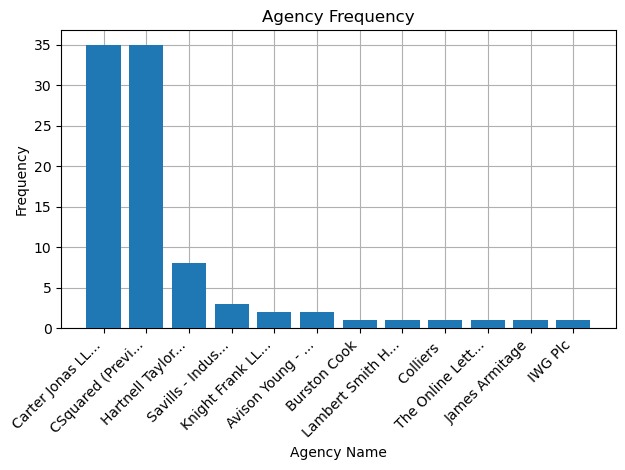

In [23]:
# Plotting bar graph by agency

import matplotlib.pyplot as plt

max_length = 15  # Adjust this value as needed

# Count occurrences of each unique category in 'Agency Name'
counts = df['Agency Name'].value_counts()

# Count occurrences of each unique category in 'Agency Name'
categories = df['Agency Name'].value_counts().index  # Unique categories
values = df['Agency Name'].value_counts().values     # Corresponding counts


categories = [name[:max_length] + '...' if len(name) > max_length else name for name in counts.index]
# Create a bar chart
plt.bar(categories, values, zorder=3)

# Add title and labels
plt.title('Agency Frequency')
plt.xlabel('Agency Name')
plt.ylabel('Frequency')
plt.grid(True, zorder=0)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [25]:
# Email draft - only if dropped - ACTUALLY DOES MAILTO NOW

for index in df_changes.index:
    if df_changes.loc[index, 'Website Status'] == 'Dropped':
# pd.set_option('display.max_colwidth', None)
        pd.set_option('display.max_colwidth', 100)

        email_body = f"""Hi {df_changes.iloc[index]['First Name']},\n 
I see that {df_changes.iloc[index]['Address']} has been taken off the wesbites. Please could you let me know the tenant, rent and lease length?\n
Thanks,\n [INSERT SIGNATURE]\n"""
        # text like this doesnt need to be indented for some reason.

        my_email = ''
        my_password = ''
        if not pd.isna(df_changes.iloc[index]['Email']):
            email_address = df_changes.iloc[index]['Email']
            # print(f'mailto:{email_address}')

            address = df_changes.iloc[index]['Address']
            subject = address[:30] + '...' 

            body = email_body.replace(' ', '%20').replace('\n','%0A')

            webbrowser.open('mailto:?to=' + email_address + '&subject=' + subject + '&body=' + body, new=1)
        # Line above doesn't do anything (as far as I can tell) if email_address variable is empty. Result - I thought it might break it.
        else:
            print('No email address found.')
        
        # print(email_body)

print(f"\n\n\n {df_changes.iloc[-1]}")





 Id                                                                                                          6975849.0
Website Status                                                                                                Dropped
Offer Status                                                                                                         
Address                                             Second Floor, 14 Queen Square, Bath, Bath and North East Somerset
Price                                                                                          £12,500.00  Per  Annum
Size                                                                                                        683 Sq Ft
Property Type                                                                                         Office, Offices
Agency Name                                                                                          Carter Jonas LLP
Agent Name                                          

In [ ]:
# Alternative method for emails - main method in box above

outlook = win32.Dispatch('outlook.application')
mail = outlook.CreateItem(0)

# Set email parameters
mail.To = email_address
mail.Subject = subject
mail.Body = email_body

mail.Display(True)